A `STARNet` workflow can be divided into two stages: STARNet model training and GRN module inference, as well as leveraging the inferred Gene Regulatory Network for downstream tasks (such as Spatial Trajectory Inference, GWAS analysis and drug response analysis).

In this tutorial, we will show how to prepare the necessary data for STARNet training. The data includes paired RNA-ATAC-seq data for the `mouse brain`. After training, we will utilize the gene and spot embedding for the downstream Gene Regulatory Network (GRN) Inference.

In [1]:
# Loading
import logging
import warnings
logging.getLogger("lightning.pytorch").propagate = False
warnings.simplefilter("ignore", FutureWarning)

import STARNet as ST
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import pickle
# import omicverse as ov

def rotate_points_90_degrees_counterclockwise(points):
    rotated_points = np.array([-points[:, 1], points[:, 0]]).T
    return rotated_points

## Stage 1: Model Training and GRN Inference

### Read data

First, we need to prepare the paired RNA-seq and ATAC-seq for the model training. We load the data from the `h5ad` format, which is a standard format for AnnData storage. For more information, please refer to this documentation[to implement]. Moreover, we need to load an additional `peak2gene file`, which contains the corresponding relationships between specific genes and positions on the chromosome.

The data used for this tutorial, which is the spatial transcriptome for the mouse brain and the peak2gene file, can be downloaded from the following links from Google Drive:

In [3]:
adata_rna = sc.read_h5ad("../../../GoogleDrive/Datasets/P21_Mouse/Raw_Data/adata_rna.h5ad")
adata_atac = sc.read_h5ad("../../../GoogleDrive/Datasets/P21_Mouse/Raw_Data/adata_atac.h5ad")

Here, we used `ST.model.STARNet` to construct a `STARNet object` to train the model. We need to specify the `RNA-seq`, `ATAC-seq`, and `peak2gene file paths` during the model initialization.

In [4]:
starnet_obj = ST.model.STARNet(adata_rna, adata_atac)

Using device: cuda


Then, we use the `preprocess()` function to prepare the transcriptomics data and construct graphs. This single function handles multiple tasks: quality control, selection of highly variable genes/peaks, data normalization, and construction of various graphs (scRNA, scATAC, cell neighbor, and peak2gene).

RNA data info:
AnnData object with n_obs × n_vars = 2373 × 19859
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_spatial'
ATAC data info:
AnnData object with n_obs × n_vars = 2373 × 135463
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'Sample'
    obsm: 'X_spatial'
Converting adata_rna.X to csr_matrix format.


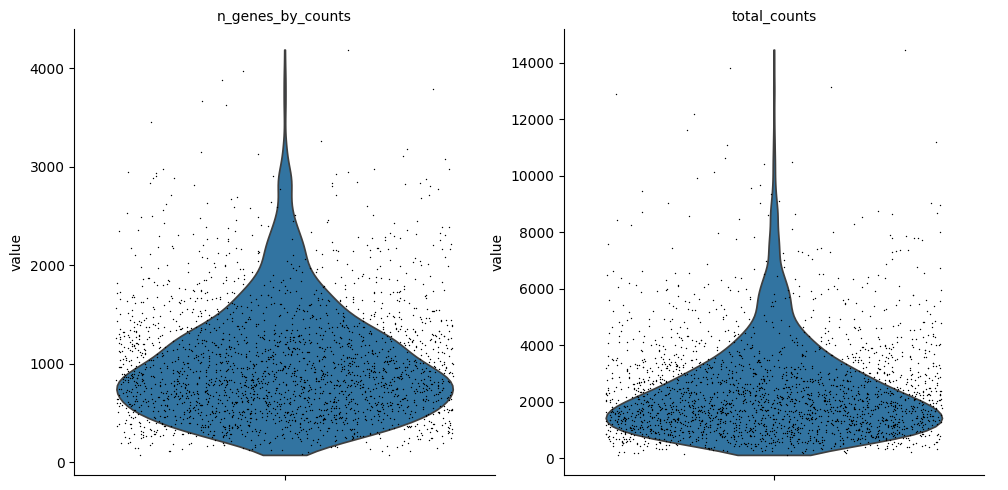

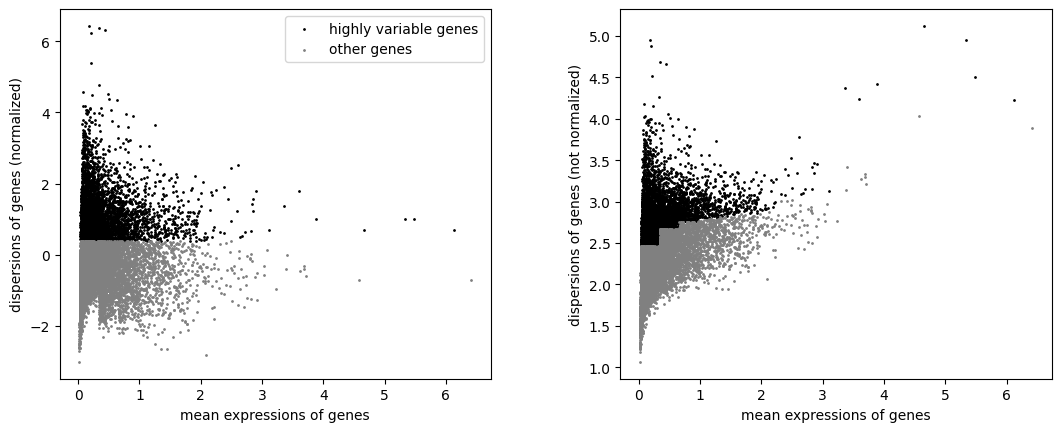

2025-08-12 02:56:59 - INFO - Selected 40000 features.


Graph data moved to device: cuda


In [5]:
starnet_obj.preprocess()

Finally, we train the model for 600 epochs, which is the recommended duration. The outputs—cell embedding and gene embedding—are saved to the obs and uns layers of the AnnData.

In [6]:
starnet_obj.train(epochs=600, eval_every=600)

Lightning model built.
Starting Lightning training...


Training: |          | 0/? [00:00<?, ?it/s]

Moving model to device: cuda

 Evaluating at epoch 600
Evaluating clustering using representation 'cell_embedding'...
Embeddings saved to adata_rna.obsm['cell_embeddings'] and adata_rna.uns['gene_embeddings']
Training finished!
TensorBoard logs saved to: ./lightning_logs/STARNet/version_0
Checkpoints saved to: ./lightning_logs/checkpoints


Plotting clustering results...


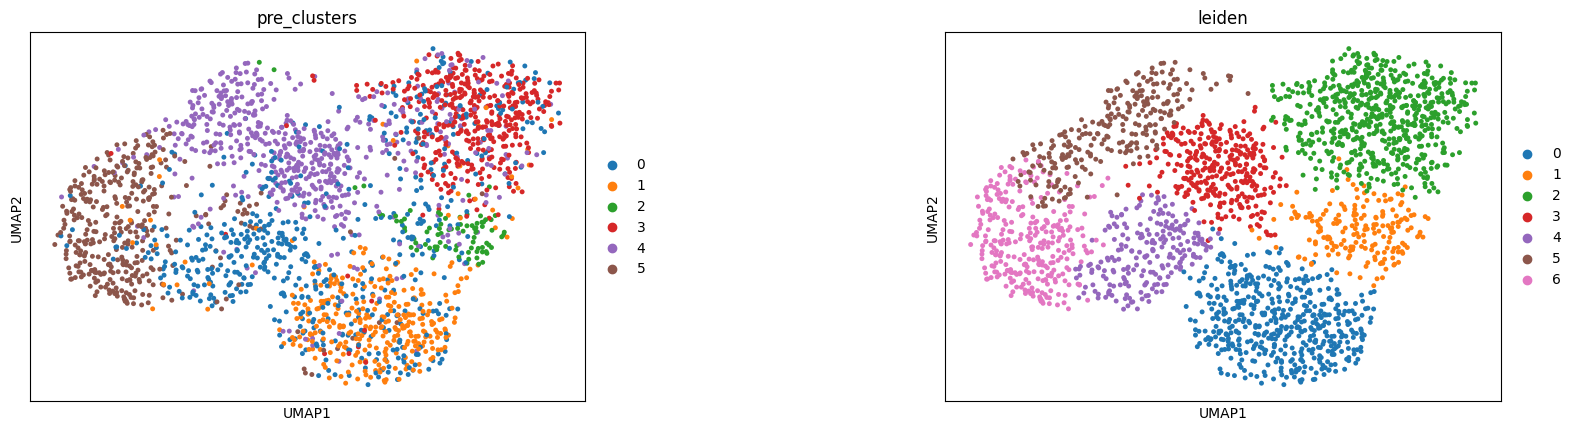

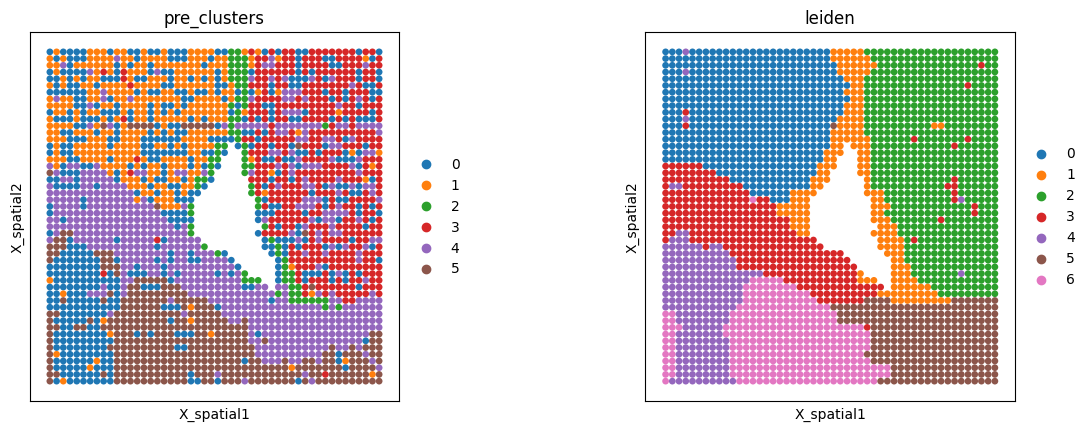

In [7]:
starnet_obj.plot_clustering_results(rep_name='cell_embedding', spot_size=1)

The AnnData for RNA-seq is shown below. We save it for later usage.

In [ ]:
print(f'RNA data after training: {starnet_obj.adata_rna}')
starnet_obj.adata_rna.write_h5ad("../GoogleDrive/fig3/Process_Data/after_training_rna.h5ad")

RNA data after training: AnnData object with n_obs × n_vars = 2373 × 11686
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt', 'leiden', 'pre_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'pct_cells', 'chrom', 'chromStart', 'chromEnd', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_version', 'gene_source', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns:

### Load multi-omics data

Here we provide two data options for the GRN Inference: one is to directly use the data you trained in stage 1, and the other is to load from your pre-trained dataset.

In [ ]:
# Load data from the trained model or from a saved state

# optional
# adata_rna = starnet_obj.adata_rna
# adata_atac = starnet_obj.adata_atac

adata_rna = sc.read_h5ad('../GoogleDrive/fig3/Process_Data/after_training_rna.h5ad')
adata_rna_raw = sc.read_h5ad("../GoogleDrive/fig3/Raw_Data/adata_rna.h5ad")
adata_atac = sc.read_h5ad("../GoogleDrive/fig3/Raw_Data/adata_atac.h5ad")

We continue to process the RNA-ATAC-seq data and add the raw counts into the `count` layer, as the later GRN calculation is based on the raw count data.

RNA data info:
AnnData object with n_obs × n_vars = 2373 × 11686
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt', 'leiden', 'pre_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'pct_cells', 'chrom', 'chromStart', 'chromEnd', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_version', 'gene_source', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'disc', '

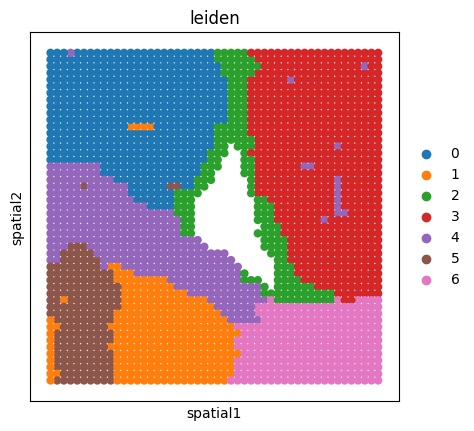

In [3]:
gene_embedding = ad.AnnData(adata_rna.uns['gene_embedding'])
gene_embedding.obs_names = adata_rna.var_names.tolist()
adata_rna.uns['gene_embedding'] = gene_embedding

adata_rna.layers['counts'] = adata_rna_raw[:,adata_rna.var_names].X
adata_atac.layers['counts'] = adata_atac.X

# Preprocess
adata_rna.obs_names = [obs_names.split('-')[0] for obs_names in adata_rna.obs_names]
adata_atac.obs_names = [obs_names.split('-')[0] for obs_names in adata_atac.obs_names]

print(f'RNA data info:\n{adata_rna}')
print(f'ATAC data info:\n{adata_atac}')

sc.pl.spatial(adata_rna,color='leiden',spot_size=1.25)

### Load Genomic Files and Inference

With all the data properly prepared, we can now load `genomic data` and begin inferring GRN from multiomics data. The `use_rep` parameter specifies which cell embedding to use. The `pvalue_regulatory` parameter filters out genes with significance greater than 0.2, while `moranI_threshold` ensures that only TFs with Moran's I values less than 0.01 are considered spatially specific and used for subsequent analysis.

In [ ]:
genomic_data_pathway = '../GoogleDrive/Genomic_data'
adata_rna = ST.grn.infer_grn_from_multiomics(adata_rna,
                                             adata_atac,
                                             genomic_data_pathway,
                                             use_rep='cell_embedding',
                                             pvalue_regulatory=0.2,
                                             moranI_threshold=0.01,
                                             n_jobs=5)

Calculate the GC proportion for all peaks.
Calculate the moran's I index for all TFs.


  0%|          | 0/100 [00:00<?, ?/s]

Perform data format standardization.
Identify the primary GRN based on the spatial co-expression relationship of genes.
Identify 148 candidate transcription factors from spatial specific genes.
Identify candidate target genes using cosine similarity of gene embeddings...


Processing TFs: 100%|██████████| 148/148 [00:01<00:00, 127.93it/s]


Calculate the metacells for spatial RNA-seq and spatial ATAC-seq data by using SEACells.
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/2373 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/2373 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/2373 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on cell_embedding
Computing diffusion components from cell_embedding for waypoint initialization ... 
Done.
Sampling waypoints ...
Done.
Selecting 26 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 15/15 [00:00<00:00, 334.42it/s]

Selecting 5 cells from greedy initialization.
Randomly initialized A matrix.


Setting convergence threshold at 0.08922
Starting iteration 1.
Completed iteration 1.
Converged after 6 iterations.
Converged after 7 iterations.
Converged after 8 iterations.
Converged after 9 iterations.
Starting iteration 10.
Completed iteration 10.
Converged after 10 iterations.


100%|██████████| 31/31 [00:00<00:00, 289.95it/s]


69.92 % candidate target genes are filtered by using pearson correlation.
Filter candidate target genes by detecting the significant regulatory peaks from the 100000 bp before and after the transcription start site of the target gene.


Processing chromosomes: 100%|██████████| 21/21 [00:09<00:00,  2.10it/s]


Loading transcripts per gene...
Preparing matrices for gene-peak associations


  0%|          | 0/11481 [00:00<?, ?it/s]/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the con

Computing peak-gene correlations


  6%|▋         | 730/11481 [01:11<24:44,  7.24it/s]/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
 64%|██████▎   | 7300/11481 [12:05<09:58,  6.98it/s]/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
 64%|██████▎   | 7310/11481 [12:07<11:16,  6.17it/s]/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWa

Perform motif scanning.
Identify the motif corresponding to specific transcription factors.


100%|██████████| 148/148 [03:08<00:00,  1.28s/it]


Identify the finally spatial related gene regulatory network.
added the original Peak2Gene to `.uns['Origin_Peak2Gene']`
added the filtered Peak2Gene to `.uns['Peak2Gene']`
added the regulatory_peaks for each TF to `.uns['regulatory_peaks']`
added the spatial-related gene regulatory network to `.uns['grn_df']`


Now, we need to extract the peak-gene association via the `Gene Transfer Format file`, which can be downloaded from the following links: [To be implemented]. This extraction is necessary because transcription factors (TFs) can bind to spatially specific cis-regulatory elements (cCREs) of DNA and activate target gene expression in spatially specific Gene Regulatory Networks (GRNs).

In [ ]:
gtf_pathway = '../GoogleDrive/Reference/gencode_vM25.chr_patch_hapl_scaff.annotation.gtf.gz'
peak2gene = ST.pp.extract_peak_gene_associations(adata_rna,gtf_file=gtf_pathway)
peak2gene.to_csv('model_out/peak2gene.links', sep="\t", index=False)

Extracting peak-to-gene associations...


Processing genes: 100%|██████████| 11481/11481 [00:43<00:00, 261.48it/s]


Found 60211 peak-gene associations. Processing coordinates...
Adding genomic coordinates for 10949 unique genes...


Adding gene coordinates: 100%|██████████| 10949/10949 [00:20<00:00, 546.49it/s]


Calculating association scores...
Filtering self-associations...
Completed processing. Returned 60122 peak-gene associations.


After obtaining the GRN and peak-gene links information, we can score each GRN and TF module to quantify the strength of a TF's influence on its target genes. This regulatory score serves two primary purposes. First, it enables clear GRN visualization by filtering for the most significant interactions. Second, in cell reprogramming analysis, these scores function as edge weights in the constructed GRN, which is then provided as a key input to the PriciCE model.

In [ ]:
# Perform permutation test on all gene regulatory networks
adata_rna = ST.pp.score_all_grn(adata_rna,n_jobs=5)

# Calculate the TF module using various clustering methods and perform cauchy combination tests
adata_rna = ST.pp.score_TF_module(adata_rna,
                                  clustering_method='mclust',
                                  n_components=30,
                                  groupby='leiden',n_jobs=5)

# Calculate the TF module using various clustering methods and perform cauchy combination tests
adata_rna = ST.pp.score_TF_module(adata_rna,
                                  clustering_method='leiden',
                                  resolution = 2,
                                  groupby='leiden',n_jobs=5)

Computing the significance of gene regulatory network with permutation test.


/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planni

added the p-values of GRN to `.uns['grn']['pval']`
added the -log10 p-values of GRN to `.uns['grn']['nlog10_pval']`
added the -log10 p-values for all GRNs to `.uns['grn']['adata_nlog10_pval']`.
Start to perform TF clustering.
running GaussianMixture clustering
finished: found 30 clusters and added 'mclust', the cluster labels (adata.obs, categorical)
Start to score TF modules.


/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/zhangxuting/CondaENV/STARNet/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planni

added the p-values of the TF modules to `.uns['TF_module']['pval']`
added the -log10 p-values of the TF modules to `.uns['TF_module']['nlog10_pval']`
added the TF genes of the TF modules to `.uns['TF_module']['TF_list']`
added the target genes of the TF modules to `.uns['TF_module']['target_gene_list']`
Start to perform cauchy combination tests for TF modules.
added the p-values of cauchy_combination_test for the TF modules to `.uns['cauchy_combination_test']`
Start to perform TF clustering.
Start to score TF modules.


100%|██████████| 11/11 [00:27<00:00,  2.47s/it]


added the p-values of the TF modules to `.uns['TF_module']['pval']`
added the -log10 p-values of the TF modules to `.uns['TF_module']['nlog10_pval']`
added the TF genes of the TF modules to `.uns['TF_module']['TF_list']`
added the target genes of the TF modules to `.uns['TF_module']['target_gene_list']`
Start to perform cauchy combination tests for TF modules.
added the p-values of cauchy_combination_test for the TF modules to `.uns['cauchy_combination_test']`


We can save the calculated and scored GRN and TF modules in `AnnData` and `pickle` formats, respectively, for later downstream analysis.

In [15]:
adata_rna.uns['grn']['adata_nlog10_pval'].T.write_h5ad("model_out/fig6_grn_nlog10_pval.adata")

with open('model_out/TF_module_30.pkl', 'wb') as f:
	pickle.dump(adata_rna.uns['TF_module'], f)

with open('model_out/TF_module_leiden_2.pkl', 'wb') as f:
	pickle.dump(adata_rna.uns['TF_module'], f)

### Visualization of GRN modules

The following cell visualizes the GRN module in spatial coordinates, which aligns well with specific areas of the mouse brain.

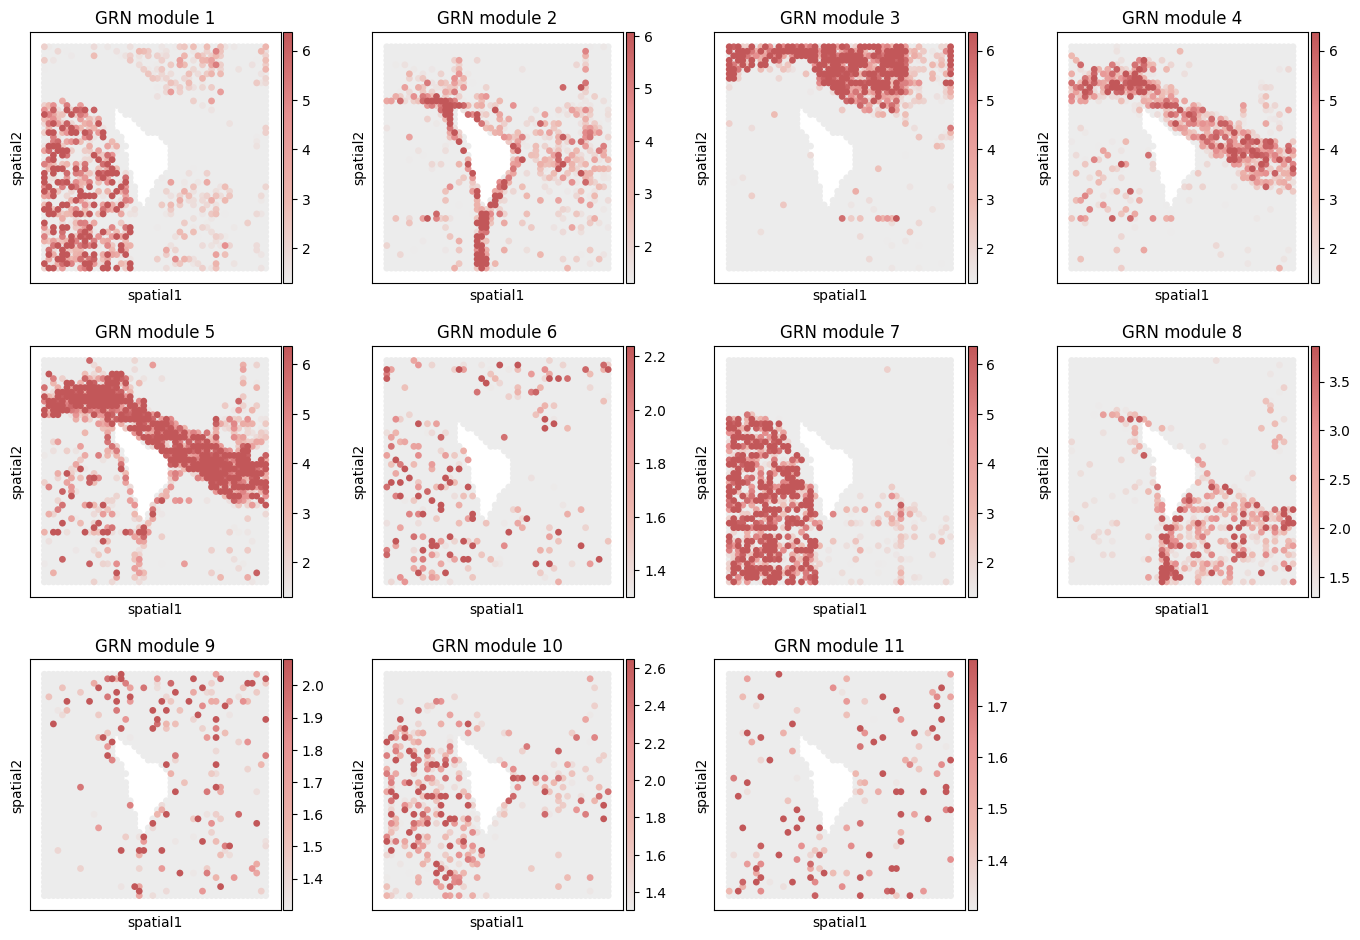

In [16]:
nlog10_pval_df = adata_rna.uns['TF_module']['nlog10_pval_df']
nlog10_pval_df = nlog10_pval_df.loc[:,[str(i) for i in range(11)]]
nlog10_pval_ad = ad.AnnData(nlog10_pval_df)
nlog10_pval_ad.obsm['spatial'] = adata_rna[nlog10_pval_ad.obs_names,:].obsm['spatial']
nlog10_pval_ad.obsm['spatial'] = rotate_points_90_degrees_counterclockwise(nlog10_pval_ad.obsm['spatial'])
nlog10_pval_ad.obsm['spatial'] = rotate_points_90_degrees_counterclockwise(nlog10_pval_ad.obsm['spatial'])
nlog10_pval_ad.var_names = ['GRN module ' + str(int(GRM)+1) for GRM in nlog10_pval_ad.var_names]

def get_cmap_seg(colors,N=256):
        from matplotlib.colors import LinearSegmentedColormap
        # Define the colors for the gradient
        colors = np.array(colors) / 255.0
        # Create a colormap from the list of colors
        cmap_name = 'custom_cmap'
        cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=N)
        return cmap

colors = [(236, 236, 236), (237, 184, 176), (230, 145, 145), (194, 87, 89)]

with plt.rc_context({"figure.figsize": (3.5,3.5)}):
    sc.pl.spatial(nlog10_pval_ad,
                  color=nlog10_pval_ad.var_names,
               #  colorbar_loc=None,
               #  frameon=False,
                  cmap=get_cmap_seg(colors),
                  legend_loc=None,
                  spot_size=1.5,
                  vmax='p98',
                  vmin=-np.log10(0.05),
                  outline_width= (0.3, 0.5),
                  ncols=4,
                  hspace=0.25,
                  wspace=0.18,
                  show=False,)


## Stage 2: Downstream Tasks

Here we demonstrate how to use the inferred GRN and TF module from the previous stage for various downstream tasks.

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU you want to use, or set to "" for CPU only

import warnings
warnings.simplefilter("ignore", FutureWarning)

import matplotlib.pyplot as plt
import STARNet as ST
import omicverse as ov
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
import scglue

data_directory = '/share/Liver_cancer/For_XUTING_20250702/STmultiVerse_reproducibility_version_3/Figure3_P21_mosue_brain'

fb=ov.pl.ForbiddenCity()
ov.plot_set()

def rotate_points_90_degrees_counterclockwise(points):
    rotated_points = np.array([-points[:, 1], points[:, 0]]).T
    return rotated_points

🔬 Starting plot initialization...
🧬 Detecting CUDA devices…
✅ [GPU 0] NVIDIA GeForce RTX 4090 D
    • Total memory: 23.6 GB
    • Compute capability: 8.9

   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

🔖 Version: 1.7.1   📚 Tutorials: https://omicverse.readthedocs.io/
✅ plot_set complete.



We load the RNA-seq data, GRN, and TF module from the last stage

In [2]:
adata_rna = sc.read_h5ad(os.path.join(data_directory, 'Process_Data/tmp_fig6_rna.h5ad'))
adata_rna.uns['grn'] = {}
adata_rna.uns['grn']['adata_nlog10_pval'] = sc.read_h5ad(os.path.join(data_directory,"Process_Data/fig6_grn_nlog10_pval.adata")).T

TF_module = ov.utils.load(os.path.join(data_directory,'Process_Data/TF_module_leiden_2.pkl'))
adata_rna.uns['TF_module'] = TF_module
print(f'RNA-seq Info: {adata_rna}')

RNA-seq Info: AnnData object with n_obs × n_vars = 2373 × 14330
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_counts', 'n_genes', 'pct_genes', 'pct_mt', 'leiden', 'pre_clusters'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'pct_cells', 'chrom', 'chromStart', 'chromEnd', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_version', 'gene_source', 'gene_biotype', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Origin_Pe

### Spatial Domain Visualization

Then, we need to recognize each specific spatial domain of the mouse brain and do the visualization.

[<Axes: title={'center': 'spatial domain_all'}, xlabel='spatial1', ylabel='spatial2'>]

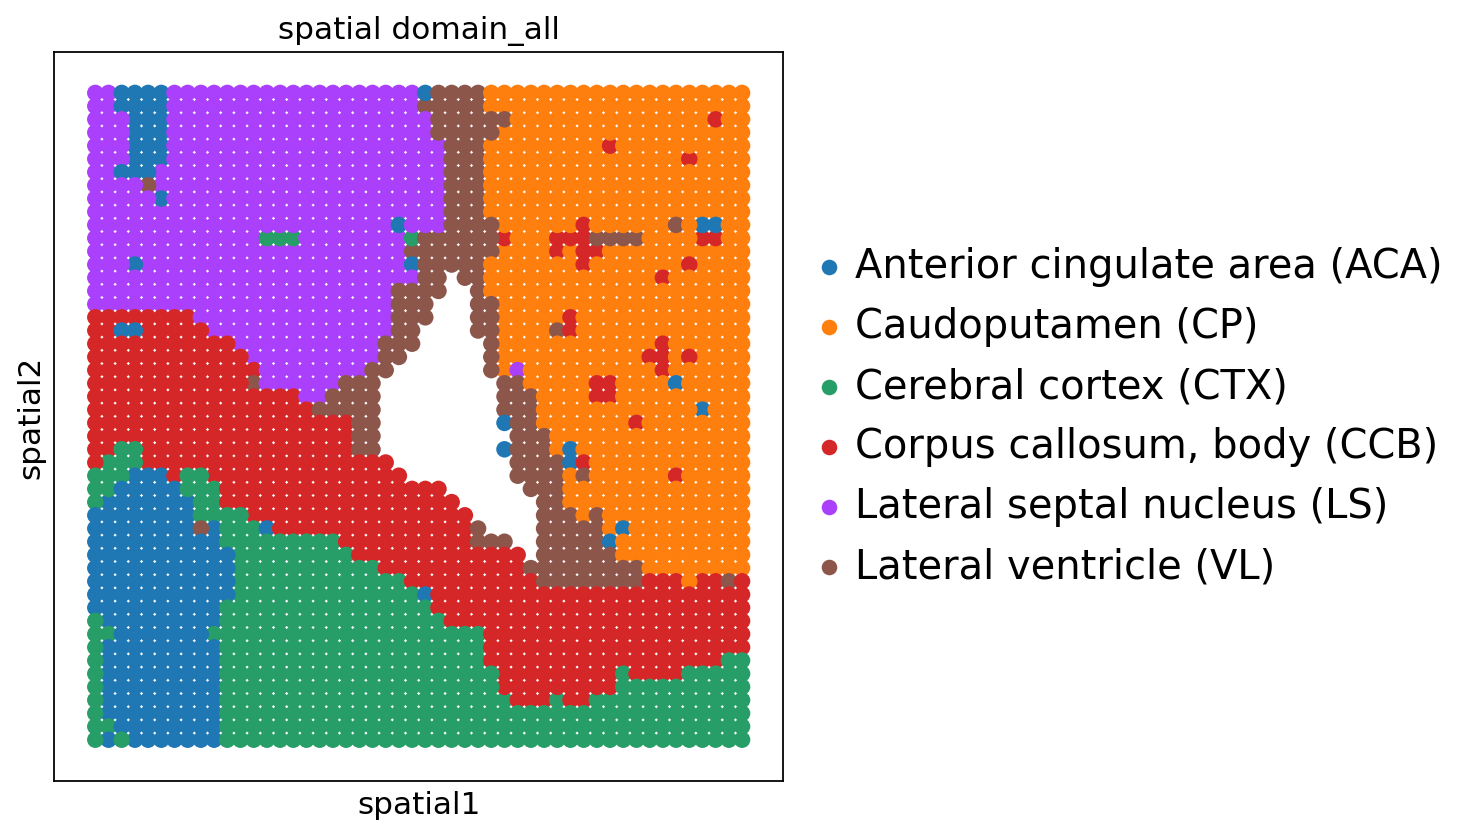

In [3]:
# Define cluster annotations
cluster2annotation = {
	'0': 'LS',
	'1': 'ACA', 
	'2': 'VL',
	'3': 'CP',
	'4': 'CCB',
	'5': 'CCB',
	'6': 'CTX',
}

cluster2annotation_full = {
	'0': 'Lateral septal nucleus (LS)',
	'1': 'Anterior cingulate area (ACA)',
	'2': 'Lateral ventricle (VL)', 
	'3': 'Caudoputamen (CP)',
	'4': 'Corpus callosum, body (CCB)',
	'5': 'Corpus callosum, body (CCB)',
	'6': 'Cerebral cortex (CTX)',
}

# Map annotations and set categories
adata_rna.obs['spatial domain'] = adata_rna.obs['leiden'].map(cluster2annotation).astype('category')
adata_rna.obs['spatial domain_all'] = adata_rna.obs['leiden'].map(cluster2annotation_full).astype('category')

# Plot spatial data
fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.spatial(adata_rna, color='spatial domain_all', spot_size=1.25, 
			  legend_fontsize=18, ax=ax, show=False, frameon=None)


### Top GRNs Visualization

The top 10 GRNs can be visualized through a horizontal bar plot that displays the aggregated p-values for each module. These values are calculated using the Cauchy combination test, with the aggregation region corresponding to the spatial domain of each module.

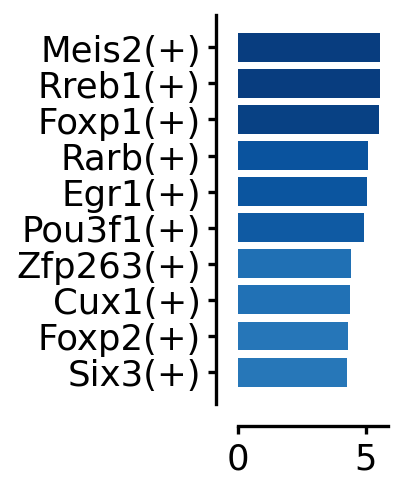

In [5]:
result_df = ST.pp.cal_cauchy_combination_test(adata_rna,'spatial domain')
result_df.index = result_df.index+'(+)'

region = 'CP'
tf_list = [i+'(+)' for i in adata_rna.uns['TF_module']['TF_list']['0']]
ax = ST.pl.horizontal_bar_chart(result_df.loc[tf_list,:].sort_values([region],ascending=False).iloc[0:10,:],
                                values=region,figsize=(1.2,3.2),fontsize=16,
                                title='',xlabel='-log$_{10}$ $\it{P}$',ylabel='',vmin=0,
                                vmax=result_df.max().max(),
                                linewidth=1.5,),
ax[0].set_xlabel('')
ax[0].tick_params(axis='y',  which='major',labelsize=16,width=1.5, ) 
ax[0].tick_params(axis='x',  which='major',labelsize=16,width=1.5, ) 

### TF-TF Interactions

Also, the TF-TF interaction network can be visualized by the following code, with the directional arrows indicating the regulatory relationships.

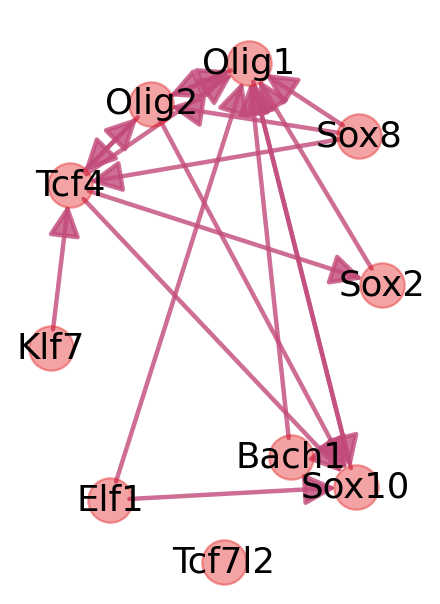

In [6]:
result_df = ST.pp.cal_cauchy_combination_test(adata_rna,'spatial domain')

tf_list = adata_rna.uns['TF_module']['TF_list']['1']
tf_list = result_df.loc[tf_list,:].sort_values(['CCB'],ascending=False).iloc[0:10,:].index
ST.pl.plot_tf_network(adata_rna, tf_list, edge_color='#C24A7A',node_color='#E31A1C',
                node_alpha=0.4,node_size=400,title='',font_size=16)

### GO Enrichment Analysis

Next, we can perform Gene Ontology (GO) term enrichment analysis for TFs and target genes associated with each module (p-values are determined by the hypergeometric test). The (+) suffix indicates GRN. The required GO Biological Process file can be downloaded from the following links [To be implemented]

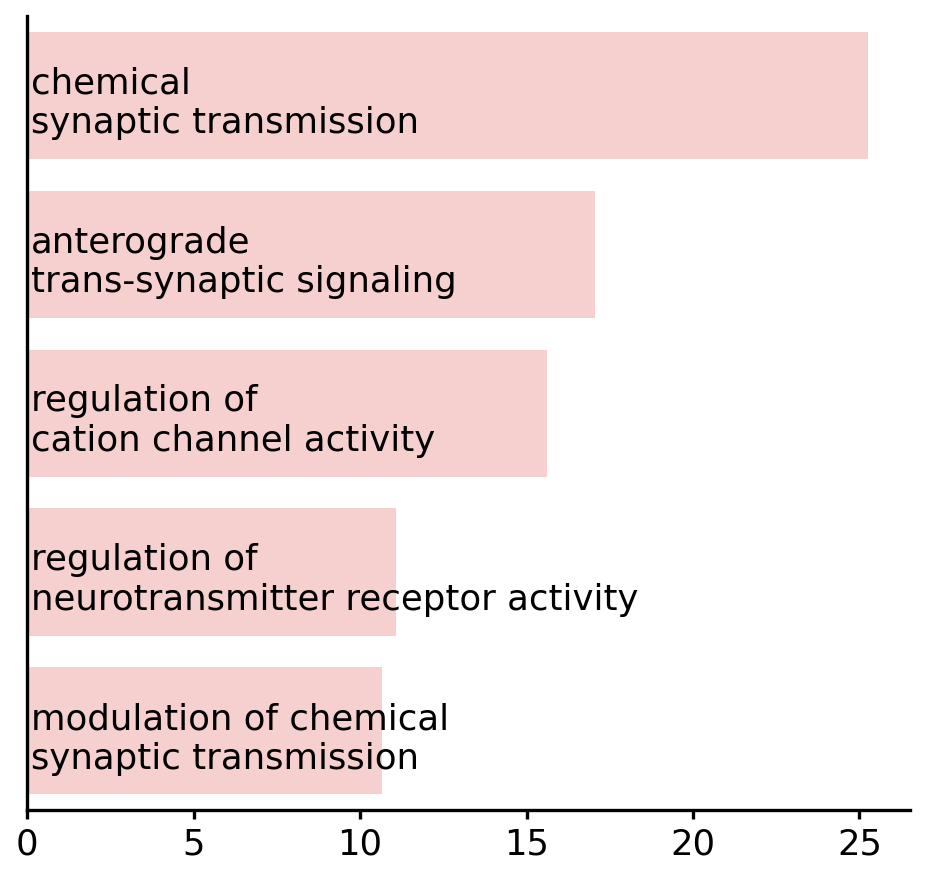

In [24]:
pathway_dict=ov.utils.geneset_prepare(os.path.join(data_directory,'genesets/GO_Biological_Process_2021.txt'),organism='Mouse')

gene_list = adata_rna.uns['TF_module']['target_gene_list']['0']
enr=ov.bulk.geneset_enrichment(gene_list=gene_list,
								pathways_dict=pathway_dict,
								pvalue_type='auto',
								organism='mouse')

# select top pathways
enr = enr.sort_values(['Adjusted P-value'],ascending=True)
enr = enr[:5]

fig,ax = ST.pl.pathway_enrichment(enr,color='#FBCAC8', threshold=30,fontsize=16,
								  title='')

ax.set_xlabel('',fontsize=16,)
plt.grid(False)
ax.tick_params(axis='x', which='major', labelsize=16, width=1.5, length=4,direction='out')
ax.tick_params(axis='y', which='major', labelsize=16, width=1.5, length=0,direction='out')


### Genometrack Plot

To visualize the GRNs for specific TFs, we need to first calculate the regulatory weight for the TFs with the target genes.

In [ ]:
grn_weight = {}
TF_list = ['Sox2','Olig2','Sox10']

for TF_id in TF_list:
    print(f'Calculate the GRN weight of {TF_id}.')
    grn_weight[TF_id] = ST.pp.grn_weight(adata_rna, tf_gene=TF_id,n_jobs=10)

ov.utils.save(grn_weight,os.path.join(data_directory, 'Result/Olig_GRN.pkl'))

Calculate the GRN weight of Sox2.


/data/CondaEnv/STARNet_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/data/CondaEnv/STARNet_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/data/CondaEnv/STARNet_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to

Identify 498 spots with Sox2 GRN pval<0.05.


100%|██████████| 122/122 [03:46<00:00,  1.86s/it]


Calculate the GRN weight of Olig2.


100%|██████████| 36/36 [00:32<00:00,  1.10it/s]


Identify 342 spots with Olig2 GRN pval<0.05.


100%|██████████| 37/37 [00:29<00:00,  1.25it/s]


Calculate the GRN weight of Sox10.


100%|██████████| 93/93 [02:45<00:00,  1.78s/it]


Identify 472 spots with Sox10 GRN pval<0.05.


100%|██████████| 94/94 [02:43<00:00,  1.74s/it]


The visualization displays GRNs formed by Sox10, Olig2, and Sox2. Nodes represent both the TFs (red) and their top target genes (pink), ranked by regulatory scores. Node size reflects each target gene's regulatory score, while edge colors differentiate the regulatory relationships associated with specific TFs.

(<Figure size 800x640 with 1 Axes>, <Axes: >)

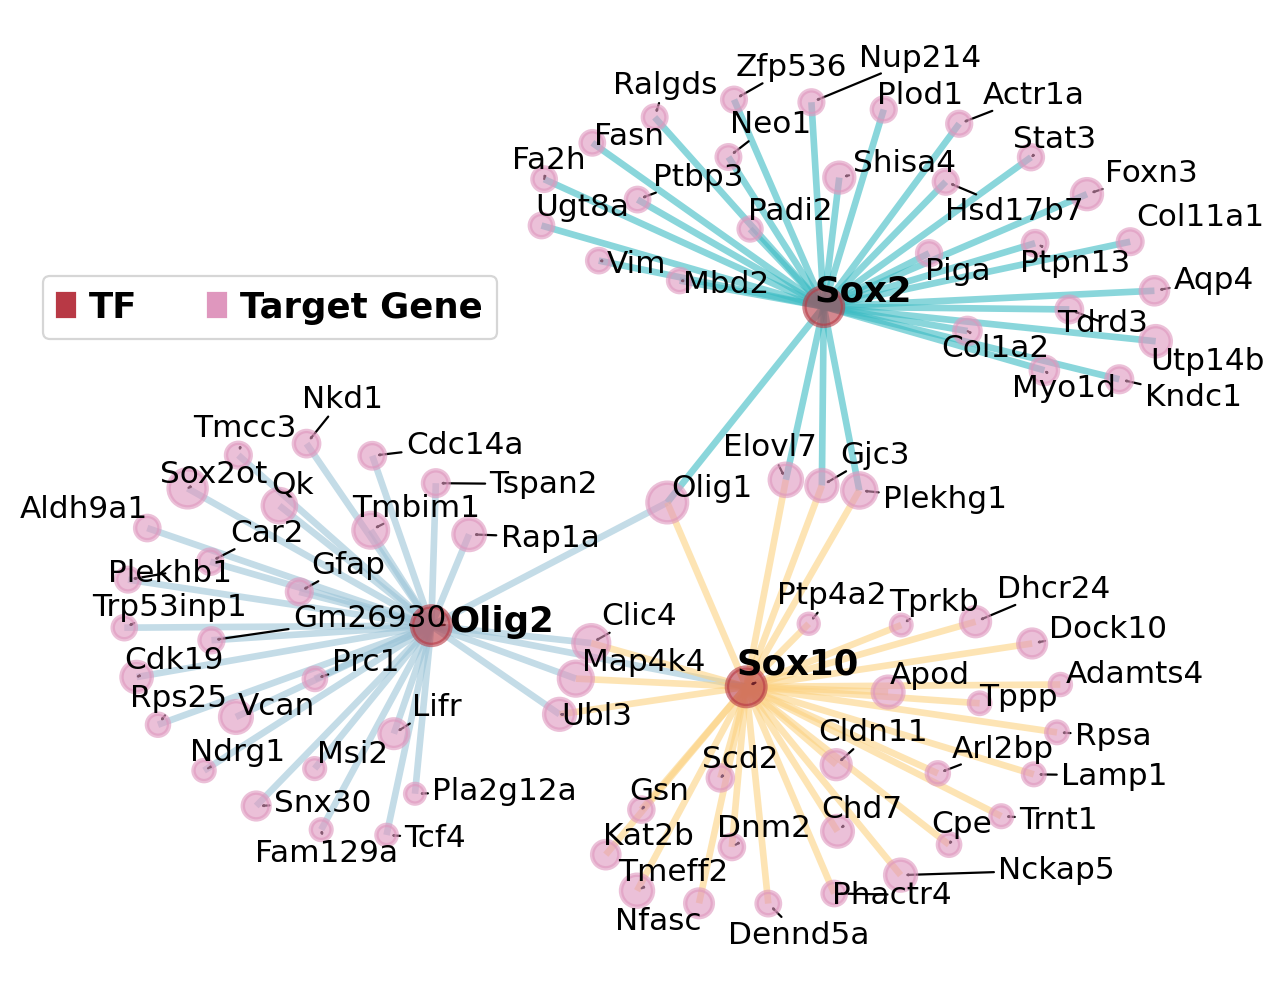

In [17]:
grn_weight = ov.utils.load(os.path.join(data_directory, 'Result/Olig_GRN.pkl'))
node_color_dict = {'tf_color': '#B83945',
                   'target_color': '#DF97BE'}
edge_color_dict = {'Sox10': '#FCD383', 
                   'Sox2': '#3CBCC4', 
                   'Olig2': '#9DC5D8', }

G, G_type_dict, node_color_dict = ST.pl.create_network(grn_weight,node_color_dict,n_top=30)            
# Add Tcf4-Olig1 edge
ST.pl.grn_network(G, G_type_dict, node_color_dict, 
                  grn_weight,
                  edge_color_dict,
                  figsize=(10,8),
                  edge_alpha=0.6,
                  edge_width=3,
                  node_alpha=0.6,
                  node_linewidths=2,
                  TF_size=300,
                  target_size=150,
                  TF_fontsize=16,
                  target_fontsize=14,
                  pos_type='kamada_kawai',
                  legend_fontsize=16,
                 # specific_gene='Olig1',
                  legend_bbox=(0.4,0.75))

### Peak2GeneLinks Visualization

To visualize the peak-to-gene linkages, we need to calculate the pseudobulk with the ATAC-seq fragments. This process creates pseudobulks in bed and bigwig formats from a single-cell fragments file for each region in spatial ATAC-seq.

In [18]:
# for the calculation of pesudobulk with fragments, please run the following code
# 'pip install pyrle'

save_pathway = (os.path.join(data_directory, 'Result/ATAC'))
region_type = 'spatial domain'
fragments_dict = {}

adata_atac = sc.read_h5ad(os.path.join(data_directory, "Raw_Data/adata_atac.h5ad"))
adata_atac = ST.pp.varnames_format_check(adata_atac)

adata_rna_copy = adata_rna.copy()
adata_rna_copy.obs_names = [i+'-1' for i in adata_rna_copy.obs_names]
adata_atac.obs['spatial domain'] = adata_rna_copy[adata_atac.obs_names].obs['spatial domain'].astype(str)

scglue.genomics.Bed(adata_atac.var).write_bed(os.path.join(data_directory, "Result/ATAC/peaks.bed"), ncols=3)
fragment = pd.read_csv(os.path.join(data_directory, 'Raw_Data/GSM6204623_MouseBrain_20um_fragments.tsv.gz'),
                       comment='#',sep='\t',header=None)

# if you are loading a mouse data, please use ST.grn.mm10_chromsizes(), if is a human data, please use ST.grn.hg38_chromsizes()
chromsizes_df = ST.grn.mm10_chromsizes()
fragment = fragment[fragment.iloc[:,0].isin(list(set(chromsizes_df['Chromosome'])))]

for domain_type in set(adata_atac.obs[region_type]):
    domain_obs_names = adata_atac[adata_atac.obs[region_type]==domain_type,:].obs_names.copy()
    fragment[fragment.iloc[:,3].isin(domain_obs_names)].to_csv(
        os.path.join(data_directory, f'Result/ATAC/{domain_type}.tsv.gz'),index=False,
        sep='\t',header=None,compression='gzip')
    
for domain_type in set(adata_atac.obs[region_type]):
    fragments_dict[domain_type] = os.path.join(save_pathway,(f'{domain_type}.tsv.gz'))

# bigwig file generation
ST.external.epiverse.pseudobulk_with_fragments(
    input_data = adata_atac.obs,
    chromsizes = chromsizes_df,
    cluster_key = region_type,
    bed_path = save_pathway,
    bigwig_path = save_pathway,
    verbose = True,
    path_to_fragments = fragments_dict,
)

Reading fragments from /share/Liver_cancer/For_XUTING_20250702/STmultiVerse_reproducibility_version_3/Figure3_P21_mosue_brain/Result/ATAC/ACA.tsv.gz
        Chromosome     Start       End                Name  Score
0             chr1   3010456   3010547  GACTAGTACAGATCTG-1      1
1             chr1   3015015   3015305  CACTTCGAACATTGGC-1      1
2             chr1   3025664   3025817  CTGAGCCAACCACTGT-1      6
3             chr1   3032427   3032840  CGACTGGAACATTGGC-1      2
4             chr1   3035801   3035849  AACGTGATATGCCTAA-1      4
...            ...       ...       ...                 ...    ...
1710679       chrY  90812823  90812883  GAATCTGACAGATCTG-1      1
1710680       chrY  90813559  90813595  CCTCCTGAATGCCTAA-1      1
1710681       chrY  90828498  90828951  CCTCCTGACATCAAGT-1      1
1710682       chrY  90828653  90828806  CGACTGGAAAACATCG-1      1
1710683       chrY  90829058  90829261  GCCACATACGCTGATC-1      2

[1710684 rows x 5 columns]
Reading fragments from /share/L

Now, before the visualization, we first load the GTF file and the pseudobulk generated in the last step.

In [ ]:
gtf_pathway = '/share/Liver_cancer/For_XUTING_20250702/Reference/gencode_vM25.chr_patch_hapl_scaff.annotation.gtf.gz'
gtf_df = ST.pp.load_gtf(gtf_pathway, adata_rna.var_names)

bw_dict={
	'Peak2GeneLink': os.path.join(data_directory, 'Result/ATAC/peak2gene.links'),
	'Peak': os.path.join(data_directory, "Result/ATAC/peaks.bed"),
	'ACA': os.path.join(data_directory, "Result/ATAC/ACA.bw"),
	'CCB': os.path.join(data_directory, 'Result/ATAC/CCB.bw'),
	'CP': os.path.join(data_directory, 'Result/ATAC/CP.bw'),
	'CTX': os.path.join(data_directory, 'Result/ATAC/CTX.bw'),
	'LS': os.path.join(data_directory, 'Result/ATAC/LS.bw'),
	'VL': os.path.join(data_directory, 'Result/ATAC/VL.bw'),
}
bw_obj=ST.external.epiverse.bigwig(bw_dict)
bw_obj.read()
bw_obj.load_gtf(gtf_pathway)

......Loading Peak2GeneLink
......Loading Peak
......Loading ACA
......Loading CCB
......Loading CP
......Loading CTX
......Loading LS
......Loading VL
......Loading gtf file


Finally, we can visualize the chromatin accessibility profiles of genomic regions spanning the Olig1 locus across different spatial domains. The peak-to-gene linkages (Peak2GeneLinks) appear as arcs, color-coded by the statistical significance of their correlations. These Peak2GeneLinks were inferred from correlations between chromatin accessibility peaks and gene expression across metacells from all spatial spots.

Text(0.7, 0.15, 'chr16:91,179,771-91,311,933')

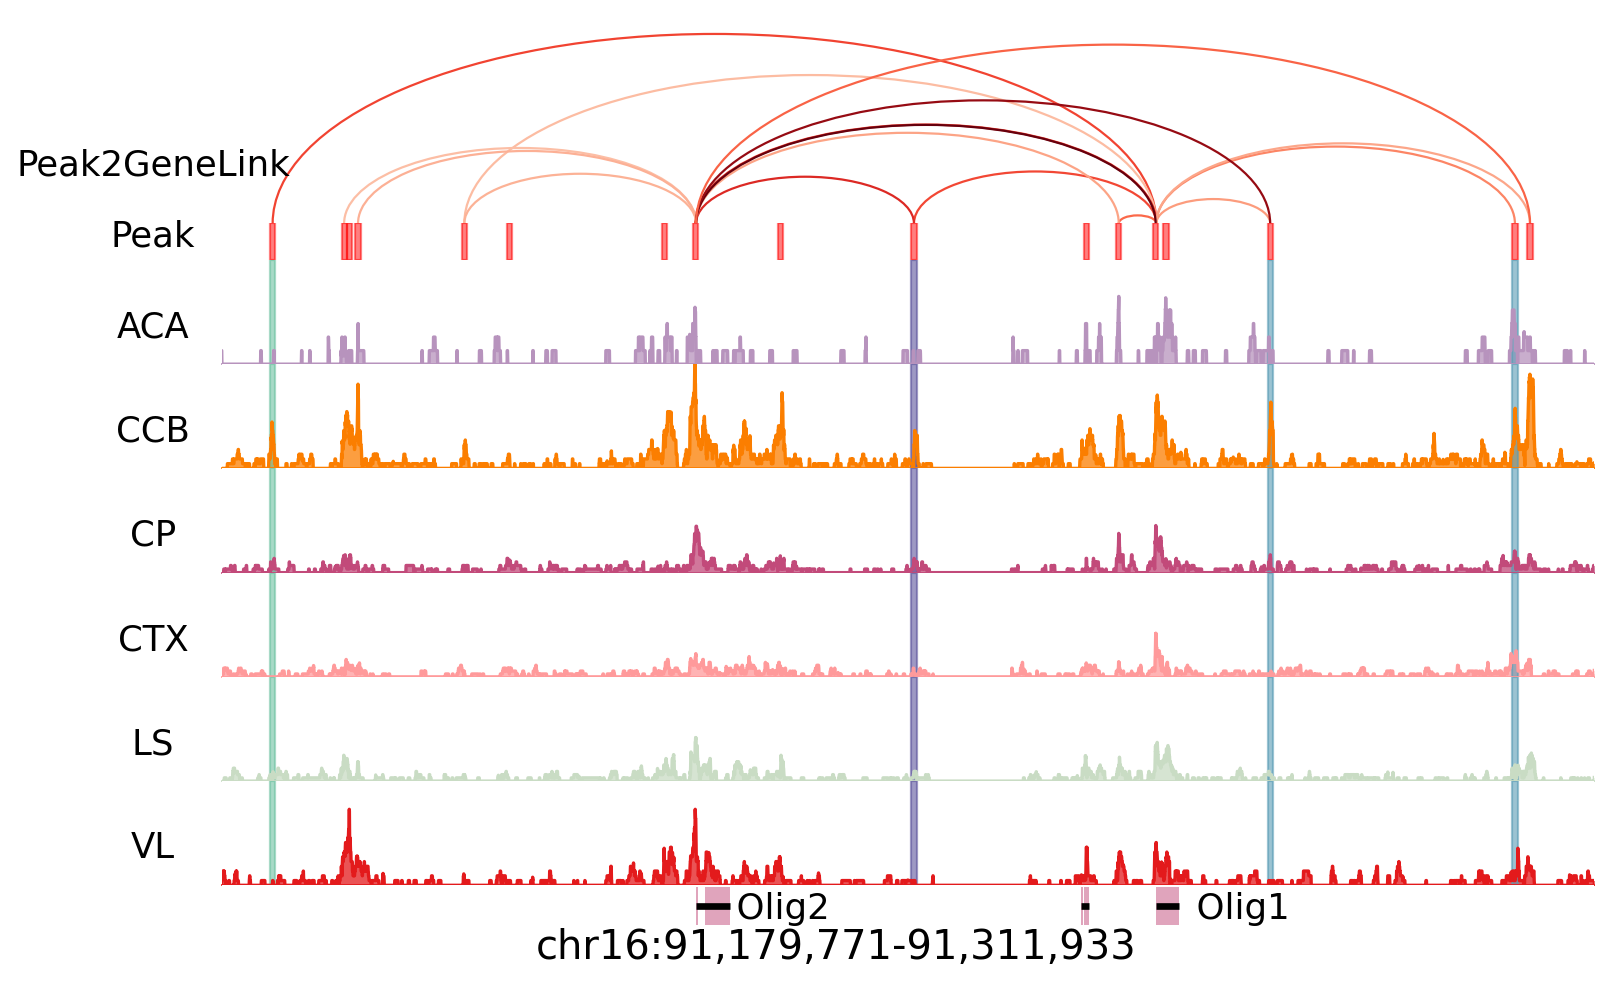

In [29]:
loc = gtf_df.loc["Olig1"]
chrom = loc["chrom"]
chromLen = 100000
chromStart = int(loc["chromStart"]) - 90000
chromEnd = int(loc["chromEnd"])  + 40000

region_dict={
    'region0':[91184443,91184944],
    'region1':[91246185,91246686],
    'region2':[91280476,91280977],
    'region3':[91304038,91304539],
}


region_color_dict={
    'region0':'#6EC2A2',
    'region1':'#5D569D',
    'region2':'#599CB4',
    'region3':'#599CB4',
}
color_dict={
    'Peak':'#FF0000',
    'ACA':'#B793BD',
    'CCB':'#FB7E00',
    'CP':'#C24A7A',
    'CTX':'#FF9A9B',
    'LS':'#c9dcc4',
    'VL':'#E31A1C',
}
subplot_height_ratios=[2,0.35,
                       1,1,1,1,1,1,
                       0.4,0]
fig,ax = bw_obj.plot_track(chrom='chr16',chromstart=chromStart,chromend=chromEnd,
                  nbins=int((chromEnd-chromStart)/10),
                  plot_names=['Peak2GeneLink','Peak','ACA','CCB','CP','CTX','LS','VL',],
                  figwidth=11,figheight=6,
                  value_type='sum',
                  subplot_height_ratios=subplot_height_ratios,
                  color_dict=color_dict,
                  region_dict=region_dict,
                  region_color_dict=region_color_dict,
                  spines=False,
                  prefered_name='gene_name',
                  ymax=45,
                  text_height=0.5,
                  text_length=1,
                  plus_gtf_color='#C24A7A',
                  minus_gtf_color='#744B7A',
                  plot_arrow=False,
                  #show_text='rowlabel',
                  ylabel_coords=(-0.05,0.2),
                  text_fontsize=16,
                  title_location=0,
                  vmax=3,
                  cmap=plt.cm.Reds,
                  plot_ymax=False,
                 )
plt.suptitle('{}:{:,}-{:,}'.format(chrom,chromStart,chromEnd),x=0.7,y=0.15,fontsize=18,horizontalalignment='right')
# fig.savefig("Figure/Main/Olig1_genometrack.pdf", dpi=300, bbox_inches = "tight")